<a href="https://colab.research.google.com/github/kaylaque/EMG/blob/main/algorithm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EMG Hand Movement Classification Using LDA and Ensembled Feature Extraction**

Kayla Queenazima Santoso

20/456076/TK/50206

Biomedical Engineering

University of Gadjah Mada

# Preparation

In [ ]:
#  loading modules

# generic libraries
import numpy as np
import itertools
import time
import random

# library for loading in matlab files
import scipy.io as sio

# loading data from web libraries
import requests
import io
import zipfile

# time series function from the statsmodels library
from statsmodels.tsa.ar_model import AR

# general machine learning functions from the sklearn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# machine learning model functions
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# dimensionality reduction functions
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# plotting library
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.mlab import find

import matplotlib.patches as mpatches


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Loading

In [ ]:
# get hand data from web and put in your working directory
req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00313/sEMG_Basic_Hand_movements_upatras.zip")
z = zipfile.ZipFile(io.BytesIO(req.content))
z.extractall()

In [ ]:
######################################################################################################################
# loading functions
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def load_hand_signals_five_subjects():
    '''
    This function loads data from Database 1 which contains
    all the sEMG signals for the experiment with five subjects.
    
    Import each subject's dictionaries into one list
    Remove any metadata in the dictionaries
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat("./Database 1/female_1.mat")
    del signal_1['__header__'] # remove metadata
    del signal_1['__globals__']
    del signal_1['__version__']
    subject_signals.append(signal_1)
    signal_2 = sio.loadmat("./Database 1/female_2.mat")
    del signal_2['__header__'] 
    del signal_2['__globals__']
    del signal_2['__version__']
    subject_signals.append(signal_2)
    signal_3 = sio.loadmat("./Database 1/female_3.mat")
    del signal_3['__header__'] 
    del signal_3['__globals__']
    del signal_3['__version__']
    subject_signals.append(signal_3)

    signal_4 = sio.loadmat("./Database 1/male_1.mat")
    del signal_4['__header__'] 
    del signal_4['__globals__']
    del signal_4['__version__']
    subject_signals.append(signal_4)
    signal_5 = sio.loadmat("./Database 1/male_2.mat")
    del signal_5['__header__'] 
    del signal_5['__globals__']
    del signal_5['__version__']
    subject_signals.append(signal_5)
    
    return subject_signals

def load_hand_signals_one_subject():
    '''
    This function loads data from Database 2 which contains
    all the sEMG signals for the experiment with a single male subject
    
    Import each subject's dictionaries into one list
    Remove any metadata in the dictionaries
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat("./Database 2/male_day_1.mat")
    
    n = len(signal_1.keys())
    
    subject_signals.append(dict(itertools.islice(signal_1.items(),3,n))) # the three removes the hand metadata
    
    signal_2 = sio.loadmat("./Database 2/male_day_2.mat")
    subject_signals.append(dict(itertools.islice(signal_2.items(),3,n))) 
    
    signal_3 = sio.loadmat("./Database 2/male_day_3.mat")
    subject_signals.append(dict(itertools.islice(signal_3.items(),3,n)))
 
    return subject_signals

def get_signal_classes(subject_signals,num_trials):
    '''
    returns a list of classes where the ith element is the class of 
    the ith signal from the subject_signals dictionary. 
    
    Note: this function returns the specific class and channel of a signal
    '''
    n = len(subject_signals)
    all_signals_classes = []
    
    for i in range(n):

        current_subject = subject_signals[i]
        class_keys = list(current_subject.keys())
        
        # repeat each class num_trails times
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys))
        all_signals_classes.extend(repeated_list) 
        
    return all_signals_classes

def get_combined_channel_classes(num_trials,num_sessions):
    '''
    returns a list of combined channel classes for the hand signals. This
    function is invoked independent of the subject_signals dictionary and is 
    written so that the ith signal in the feature vector of signals x has its ith
    class being the ith element of the y returned by this function.
    '''
    y = []
    class_keys_new = ['cyl','hook','tip','palm','spher','lat']
    for i in range(num_sessions):
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys_new))
        y.extend(repeated_list)
    return y

def segment_signal(signal, window_length = 4, overlap_length = 2, copy = False):
    '''
    segment a signal into windows of size window_length and which overlap with
    size overlap_length. This function returns an array which contains these segments
    as subarrays.
    '''
    sh = (signal.size - window_length + 1, window_length)
    st = signal.strides * 2
    
    # numpy trick for fast segmentation
    view = np.lib.stride_tricks.as_strided(signal, strides = st, shape = sh)[0::overlap_length] 
    if copy:
        return view.copy()
    else:
        return view


In [ ]:
one_subject = load_hand_signals_one_subject()
five_subject = load_hand_signals_five_subjects()

In [ ]:
print(len(one_subject))
print(len(one_subject[2]))
print(len(one_subject[2]['spher_ch2'][0]))
print(one_subject[0].keys())

3
12
2500
dict_keys(['cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])


In [ ]:
print(len(five_subject))
print(len(five_subject[2]))
print(len(five_subject[2]['spher_ch2'][0]))

5
12
3000


#Visualization

In [ ]:
###############################################################################################################
# visualization and dimensionality reduction
    
def visualization(x,y,num_classes,legend=True, method="tsne"):
     '''
     Uses dimensionality reduction to visualize a feature matrix x and class vector y. This
     function colors each class a different color and if legend=TRUE, 
     the plot includes a legend which shows which class each color represents. 
     
     Note: suppored methods are t-sne and pca. 
     '''
     mydict = {} # this first chunk of code encodes class strings as numbers
     i = 0
     for item in y:
         if(i>0 and item in mydict):
             continue
         else:    
            i = i+1
            mydict[item] = i

     k=[]
     for item in y:
         k.append(mydict[item])
    
     if method == "tsne":
         Y = TSNE(2,init='pca').fit_transform(x) # TSNE function is from sklearn.manifold
         
     elif method == "pca":
         Y = PCA(2).fit_transform(x)    
         
     colors = ['red','green','blue','purple','yellow','black',
                   'pink','violet','teal','orchid','lime','cyan','gold','silver','magenta']
     colors = colors[:num_classes]
     plt.scatter(Y[:,0], Y[:,1], c=k, cmap=matplotlib.colors.ListedColormap(colors))     
     frame1 = plt.gca() # gca, gcf used to manipute axes and plot size 
     frame2 = plt.gcf()
     
     frame1.axes.xaxis.set_ticklabels([])  # hide the axis labels and tick marks since they are irrelevant for tsne and pca visualizations
     frame1.axes.yaxis.set_ticklabels([])
     frame1.axes.xaxis.set_ticks([])
     frame1.axes.yaxis.set_ticks([])
     frame2.set_size_inches(10, 10) 
     if legend == True:

         unique_classes = [e for i, e in enumerate(y) if y.index(e) == i]
         recs=[]
         for i in range(0,len(colors)):
             recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i])) # manually add legend

         plt.legend(recs,unique_classes,loc=0,fontsize = 'large') # put legend in 'best' location

     plt.show()
     
def combine_channels(x,num_trials):
    '''
    combines the hand data channels; for instance, cyl_ch1 and cyl_ch2
    turn into cyl. The features vector of cyl_ch1 is appended onto
    the end of feature vector of cyl_ch2 to get feature vector of cyl
    '''
    n = len(x)
    x_new = [0]*int((n/2)) # new list will be half the size
    i = 0
    k = 0
    while i != n: 
        x_new[k]= x[i]+x[i+num_trials]
        i += 1
        k += 1
        if (i+num_trials) % num_trials == 0:
            i = i+num_trials
    return x_new


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

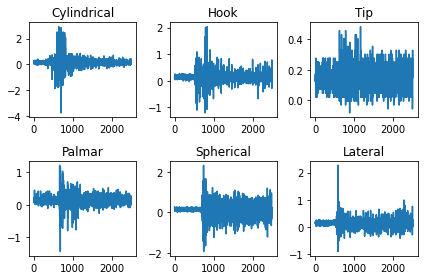

In [ ]:
# plt.plot(one_subject[0]['spher_ch1'][0,:])
fig = plt.figure()
plt.subplot(2, 3, 1)
plt.subplot(2, 3, 1).set_title('Cylindrical')
plt.plot(one_subject[0]['cyl_ch1'][0,:])
plt.subplot(2, 3, 2)
plt.subplot(2, 3, 2).set_title('Hook')
plt.plot(one_subject[0]['hook_ch1'][0,:])
plt.subplot(2, 3, 3)
plt.subplot(2, 3, 3).set_title('Tip')
plt.plot(one_subject[0]['tip_ch1'][0,:])
plt.subplot(2, 3, 4)
plt.subplot(2, 3, 4).set_title('Palmar')
plt.plot(one_subject[0]['palm_ch1'][0,:])
plt.subplot(2, 3, 5)
plt.subplot(2, 3, 5).set_title('Spherical')
plt.plot(one_subject[0]['spher_ch1'][0,:])
plt.subplot(2, 3, 6)
plt.subplot(2, 3, 6).set_title('Lateral')
plt.plot(one_subject[0]['lat_ch1'][0,:])
fig.tight_layout()  

# Preprocessing


In [ ]:
from scipy import signal

In [ ]:
def lfilter(inp, order): # defining Lfilter
    nyq = 1000 / 2.0
    low = 47 / nyq 
    high = 53/ nyq
    b, a = signal.iirfilter(order,[low,high ], btype='bandstop',ftype='butter')
    output = signal.lfilter(b, a, inp)
    return output

In [ ]:
def iirfilter(inp, order): #defining iirfilter   (we will not use it , putting it for illustration)
    
    b, a = signal.iirfilter(order, [47/1000, 53/1000], btype='bandstop')
    output = signal.freqs(b, a, inp)
    return output

In [ ]:
#example
palmar_filtered=lfilter(inp=one_subject[0]['palm_ch1'][0,:],order=6)
lateral_filtered=lfilter(inp=one_subject[0]['lat_ch1'][0,:],order=6)
lateral_filtered.shape

(2500,)

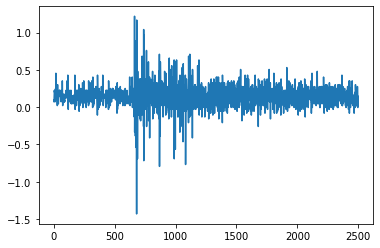

In [ ]:
plt.plot(one_subject[0]['palm_ch1'][0,:])

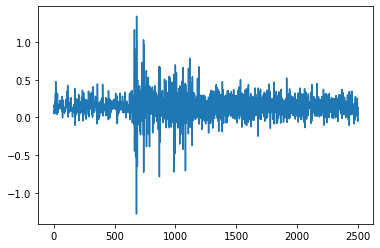

In [ ]:
plt.plot(palmar_filtered) #ploting the first row of palmar after applying filter

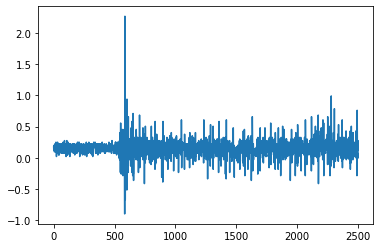

In [ ]:
plt.plot(one_subject[0]['lat_ch1'][0,:])

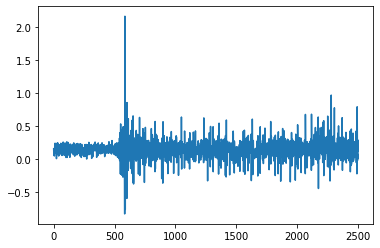

In [ ]:
plt.plot(lateral_filtered) #ploting the first row of palmar after applying filter

#####Mean Removed

In [ ]:
# if using IPython: check variables from previous lesson are still in workspace
# %whos

# process EMG signal: remove mean
def mean(emg):
  emg_correctmean = emg - np.mean(emg)
  return(emg_correctmean)

#####Filter EMG signal

In [ ]:
import scipy as sp
from scipy import signal

def filter(emg):
  # create bandpass filter for EMG
  high = 20/(1000/2)
  low = 450/(1000/2)
  b, a = sp.signal.butter(4, [high,low], btype='bandpass')

  # process EMG signal: filter EMG
  emg_filtered = sp.signal.filtfilt(b, a, emg)
  return(emg_filtered)

#####Rectified EMG

In [ ]:
def rectify(emg):
  # process EMG signal: rectify
  emg_rectified = abs(emg)
  return(emg_rectified)

#####Processed EMG

In [ ]:
processed_emg = []
for j in range(len(five_subject)):
  a_subject = dict.fromkeys(five_subject[j].keys(), [])
  for i in five_subject[j].keys():
    a_subject[i] = rectify(mean(filter(five_subject[j][i][:,:])))
    
  processed_emg.append(a_subject)

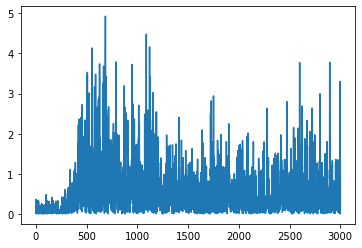

In [ ]:
plt.figure()
plt.plot(processed_emg[0]['cyl_ch1'][0,:])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

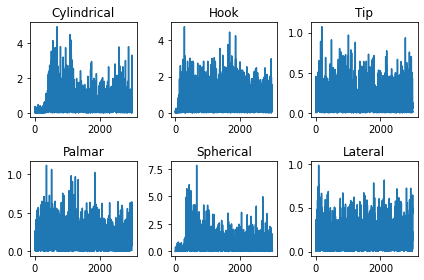

In [ ]:
# plt.plot(one_subject[0]['spher_ch1'][0,:])
fig = plt.figure()
plt.subplot(2, 3, 1)
plt.subplot(2, 3, 1).set_title('Cylindrical')
plt.plot(processed_emg[0]['cyl_ch1'][0, :])
plt.subplot(2, 3, 2)
plt.subplot(2, 3, 2).set_title('Hook')
plt.plot(processed_emg[0]['hook_ch1'][0, :])
plt.subplot(2, 3, 3)
plt.subplot(2, 3, 3).set_title('Tip')
plt.plot(processed_emg[0]['tip_ch1'][0, :])
plt.subplot(2, 3, 4)
plt.subplot(2, 3, 4).set_title('Palmar')
plt.plot(processed_emg[0]['palm_ch1'][0, :])
plt.subplot(2, 3, 5)
plt.subplot(2, 3, 5).set_title('Spherical')
plt.plot(processed_emg[0]['spher_ch1'][0, :])
plt.subplot(2, 3, 6)
plt.subplot(2, 3, 6).set_title('Lateral')
plt.plot(processed_emg[0]['lat_ch1'][0, :])
fig.tight_layout()  

In [ ]:
print(len(processed_emg))
print(len(processed_emg[2]))
print(len(processed_emg[2]['spher_ch2'][0]))

5
12
3000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Feature extraction

In [ ]:
##################################################################################################################
# feature functions

def ar_coefficients_stat_models(signal, ar_parameter): # from statmodels
    '''
    calculate the autoregressive coefficients of a time series (signal in this case).
    
    input: signal_segments, which is the signal split into segments, and 
    ar_parameter for order of auto-regressive model
    output: ar_parameter number of coefficients
    '''
    ar_mod = AR(signal)
    ar_res = ar_mod.fit(ar_parameter,trend='nc') # trend removes constant term
    ar_coefficients = ar_res.params

    return ar_coefficients.tolist()
    
def wamp_formula(numpy_array, threshold = .00005): 

    n = len(numpy_array)
    wamp=0
    for i in range(n-1):
        if (abs(numpy_array[i]-numpy_array[i+1]) > threshold):
            wamp += 1
    return wamp


def wilson_amplitude(signal_segments): 
    '''
    Wilson Amplitude is a feature which is the number
    of times that the difference between two consecutive amplitudes
    in a time segment exceeds a threshold, which can be anything but set
    here to 50 uV (microvolts)
    
    input: signal_segments, which is a signal split into segments
    output: list containing the wilson amplitude of each window at each stride
    '''
    feature_list = list(map(wamp_formula,signal_segments))
        
    return feature_list


def rms_formula(signal):

    rms_of_signal = np.sqrt(np.mean(np.power((signal),2)))

    return rms_of_signal
    
def rms_window(signal_segments): 
    '''
    Root Mean Square is an feature which averages a signal
    
    input: signal_segments, which is a signal split into segments
    output: list containing the rms of each window at each stride
    '''
    feature_list = list(map(rms_formula,signal_segments))

    return feature_list
    
def var_formula(signal):

    return np.var(signal)
    
def variance(signal_segments): 
    '''
    Variance measures how varied a signal is
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the variance of each window at each stride
    '''
    feature_list = list(map(var_formula,signal_segments))

    return feature_list

def wl_formula(signal):

    n = len(signal)
    wl_of_signal = (1/(n-1))*sum(abs(signal[l]-signal[l-1]) for l in range(1,n))

    return wl_of_signal

def waveform_length(signal_segments): 
    '''
    Waveform Length is the average distance between two peaks or troughs in a signal
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the waveform length of each window at each stride
    '''
    feature_list = list(map(wl_formula,signal_segments))

    return feature_list


def mav_formula(signal):

    n = len(signal)
    mav_of_signal = (1/n)*sum(abs(signal[l]) for l in range(n))

    return mav_of_signal


def mean_absolute_value(signal_segments):
    '''
    Mean Absolute Value is another measure of average which sums rectified signal point
    and divides this by the number of signal points
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the mean absolute value of each window at each stride
    '''
    
    feature_list = list(map(mav_formula,signal_segments))       
            
    return feature_list   

def zc_formula(numpy_array, threshold = .0005): # 0.05 mV by default 

    n = len(numpy_array)
    zc=0
    for i in range(1,n-1):
        if ((numpy_array[i]-threshold)*(numpy_array[i-1]-threshold) < 0):
            zc += 1
    return zc


def zero_crossing(signal_segments): # works, look into threshold
    '''
    Zero Crossing is a feature which is the number
    of number of times the signal crosses zero on the amplitude
    axis
    
    input: signal_segments is signal split into segments
    output: list consisting of the zero crossing number of each window at each stride
    '''
    feature_list = list(map(zc_formula,signal_segments))
        
        
    return feature_list

def ssc_formula(numpy_array, threshold = .2*(10**-9)): # 0.2 nV by default 

    n = len(numpy_array)
    ssc=0
    for i in range(1,n-1):
        if (((numpy_array[i]-numpy_array[i-1])*(numpy_array[i]-numpy_array[i+1])) > threshold):
            ssc += 1
    return ssc


def sign_slope_changes(signal_segments): 
    '''
    Sign Slope Changes is the number of times the slope of the emg signal changes sign
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the sign slope changes number of each window at each stride
    '''
    feature_list = list(map(ssc_formula,signal_segments))
        
    return feature_list
  
def feature_extraction(processed_signals, feature_name_list, window_length = 100, overlap_length = 1, ar_parameter = 0):
    '''
        This function extracts features from the provided list of signals. For each singal, features
        are extracted and appended one after to form a feature representation of the signal as a list.
        These feature lists are then appended one after another to create a big list with all feature information.
        
        input: 1) processed_signals is list of dictionaries: each subject all his/her
                  signals and associated classes as a dictionary
               2) class_name_list is list of strings, one for each class
               3) feature_name_list is list of features to extract from signals,
                  DOES NOT include AR or other non-window features
               4) window_length is size of each window, overlap_length is amount of
                  overlap between windows, and ar_parameter is the order of the auto-
                  regressive model

        output: list of all feature representations of the signals
     
        Note:
        class list looks like ['cyl_ch1','cyl_ch2','hook_ch1','hook_ch2','tip_ch1','tip_ch2'
        ,'palm_ch1','palm_ch2','spher_ch1','spher_ch2','lat_ch1','lat_ch2']
        
    '''
    ti = time.time() # time the feature extraction process
    
    num_subjects = len(processed_signals)
    num_features = len(feature_name_list)
    num_classes = len(list(processed_signals[0].keys()))
    all_signals_features_list = list([])
    total_current_feature_list = list([])
    
    for i,j in itertools.product(range(num_subjects),range(num_classes)):

        current_subject = processed_signals[i]

        current_class = list(processed_signals[i].keys())[j]

        if ar_parameter != 0: # ar_parameter = 0 means we do not use this feature

            total_current_feature_list = list(map(lambda x: ar_coefficients_stat_models(x,ar_parameter),current_subject[current_class]))

        segmented_current_signal = np.array(list(map(lambda x: segment_signal(x,window_length,overlap_length),current_subject[current_class]))) #break signals up into windows
        
        for k in range(num_features):
            
            possibles = globals().copy() # this is a work around to be able to call a function when given its string name
            possibles.update(locals())
            method_to_call = possibles.get(feature_name_list[k]) # call function from feature name list
            current_feature = map(method_to_call, segmented_current_signal)

            if k > 0 or ar_parameter != 0:

                total_current_feature_list = list(map(list, zip(total_current_feature_list,current_feature)))
        
                total_current_feature_list = list(map(lambda x: sum (x, []),total_current_feature_list))
    
            else:

                total_current_feature_list = list(current_feature)
        
        if j==0: # check progress at each start of each session
            print("Feature Extraction Progress")        
            print("session num: (out of "+str(num_subjects)+")",i+1,"class num: (out of 12) " ,j+1) # optional to see where your at, maybe use for long running feature extraction combos
        all_signals_features_list.extend(total_current_feature_list)

    tf = time.time()
    print("Feature Extraction Total Runtime:" ,(tf-ti)/60,"mins")
    return all_signals_features_list


In [ ]:
four_features = ['rms_window', 'variance', 'waveform_length', 'mean_absolute_value'] #4 FE
all_features = ['wilson_amplitude', 'rms_window', 'variance', 'waveform_length', 'mean_absolute_value', 
                'zero_crossing', 'sign_slope_changes']

## one subject 



Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.31274981498718263 mins
wilson_amplitude


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


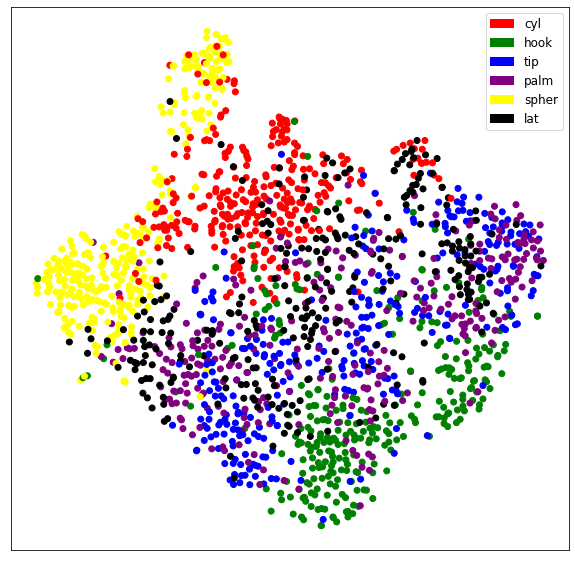

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.1781822681427002 mins
rms_window


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


KeyboardInterrupt: ignored

In [ ]:
num_trials = 100
num_sessions = 3 # one subject on three different days
for i in all_features:
  features_signals = feature_extraction(one_subject,feature_name_list=[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 6)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  print(i)
  visualization(x,y,num_classes=6,legend=True,method="tsne")

## 5 subject

In [ ]:
num_trials = 30
num_sessions = 5 # one subject on three different days
for i in all_features: #all features one by one
  features_signals = feature_extraction(processed_emg,feature_name_list=[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  print(i)
  visualization(x,y,num_classes=6,legend=True,method="tsne")

In [ ]:
num_trials = 30
num_sessions = 5 # five subject on three different days
#all features overlapped
features_signals = feature_extraction(five_subject,feature_name_list=all_features,window_length = 128, overlap_length = 64, ar_parameter = 11)
x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)
visualization(x,y,num_classes=6,legend=True,method="tsne")

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.25213637749354045 mins


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


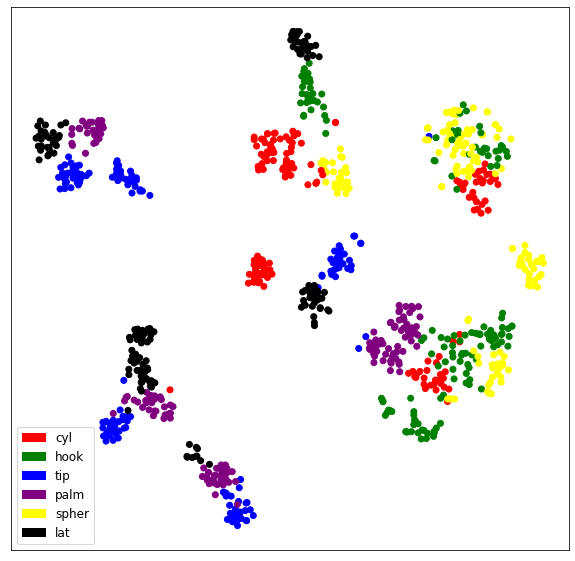

900


In [ ]:
num_trials = 30
num_sessions = 5 # one subject on three different days
# one specific feature
features_signals = feature_extraction(five_subject,feature_name_list=['variance'],window_length = int(128), overlap_length = int(64), ar_parameter = 11)
x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)
visualization(x,y,num_classes=6,legend=True,method="tsne")
print(len(y))

# Classify

In [ ]:

##################################################################################################################
# classifier functions
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB, ComplementNB
def adaboost():

    return AdaBoostClassifier(n_estimators=100, random_state=0)
def qda():

    return QuadraticDiscriminantAnalysis()

def lda():

    return LinearDiscriminantAnalysis()

def svm():

    return SVC(kernel = 'rbf') 

def random_forest():

    return RandomForestClassifier(random_state=5)

def extra_trees():

    return ExtraTreesClassifier(random_state = 10)

def grad_boost():
    
    return GradientBoostingClassifier(random_state = 8)

def gnb():

    return GaussianNB()


def classification_train_test(all_signals_fearures_list, all_signals_classes, classifier_string = 'qda',dataset_type = "one_subject"):       
    '''
    This function takes a list of signals (represented by extracted features) and a list of the classes
    corresponding to each signal. Then this function trains the given classifier and
    tests the classifier on hold out data (last session or last subject depending on dataset).
    The test accuracy as well as a classification report is printed out.
    
    Note: classifier_strings are either qda,lda,svm, random forest, extra trees, and grad_boost
    '''
    if dataset_type == "one_subject":
        # test on third session, train on first two
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:1199],all_signals_fearures_list[1200:], all_signals_classes[:1199], all_signals_classes[1200:]
   
    if dataset_type == "five_subjects":
        # test on last male subject, train on other four
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:719],all_signals_fearures_list[720:],all_signals_classes[:719], all_signals_classes[720:]
    
    possibles = globals().copy()
    possibles.update(locals())
    method_to_call = possibles.get(classifier_string) # call function from feature name list
    clf = method_to_call()
    # selector = RFE(clf)
    selector = clf.fit(train_sigs, train_sigs_classes)

    prediction_classes = clf.predict(test_sigs) # testing the classifier
    actual_classes = test_sigs_classes 
    
    print("Baseline Random is 16.7%",end="\n")
    print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    print(classification_report(actual_classes,prediction_classes))
    # print(selector.ranking_)
    return clf

In [ ]:
model = classification_train_test(x,y, classifier_string = 'lda', dataset_type = "five_subjects")

Baseline Random is 16.7%
Accuracy on test set is:  48.0 %
              precision    recall  f1-score   support

         cyl       0.41      0.23      0.30        30
        hook       0.44      0.77      0.56        30
         lat       0.00      0.00      0.00        30
        palm       0.45      0.17      0.24        30
       spher       0.81      0.70      0.75        30
         tip       0.48      1.00      0.65        30

    accuracy                           0.48       180
   macro avg       0.43      0.48      0.42       180
weighted avg       0.43      0.48      0.42       180



# Deployment and Saving Model

In [ ]:
import pickle

# save the model to disk
pickle.dump(model, open('variance_LDA_weight', 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open('variance_LDA_weight', 'rb'))
num_trials = 30
num_sessions = 5 # one subject on three different days
features_signals = feature_extraction(five_subject,feature_name_list=['variance'],window_length = 128, overlap_length = 64, ar_parameter = 11)
x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)
prediction_classes = loaded_model.predict(x) # testing the classifier with trained dataset
actual_classes = y 
    
print("Test on FIVE SUBJECT DATABASE",end="\n")
print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
print(classification_report(actual_classes,prediction_classes))

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.2882204532623291 mins
Test on FIVE SUBJECT DATABASE
Accuracy on test set is:  79.0 %
              precision    recall  f1-score   support

         cyl       0.83      0.82      0.83       150
        hook       0.79      0.90      0.84       150
         lat       0.71      0.67      0.69       150
        palm       0.79      0.67      0.72       150
       spher       0.95      0.85      0.90       150
         tip       0.67      0.81      0.74       150

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79  

#Combination Codes: Feature extraction till Deployment

#####In loop: all features extraction with all classifier wo pre-process

In [ ]:
import pickle
import warnings
%cd '/content/drive/MyDrive/SEM 04/TPIB/proyek mandiri-Kayla/model'
num_trials = 30
num_sessions = 5 # one subject on three different days
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # sklearn gives future warning which is not relevant here
classifier_list = ['qda','lda', 'svm', 'random_forest', 'extra_trees', 'grad_boost', 'gnb', 'adaboost']
four_features = ['rms_window', 'variance', 'waveform_length', 'mean_absolute_value'] #4 FE
all_features = ['wilson_amplitude', 'rms_window', 'variance', 'waveform_length', 'mean_absolute_value', 
                'zero_crossing', 'sign_slope_changes']
mode = 'wo-PP' #mode without pre-processing

/content/drive/MyDrive/SEM 04/TPIB/proyek mandiri-Kayla/model


--------------------------------------------------------------
wilson_amplitude
Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.27843579053878786 mins


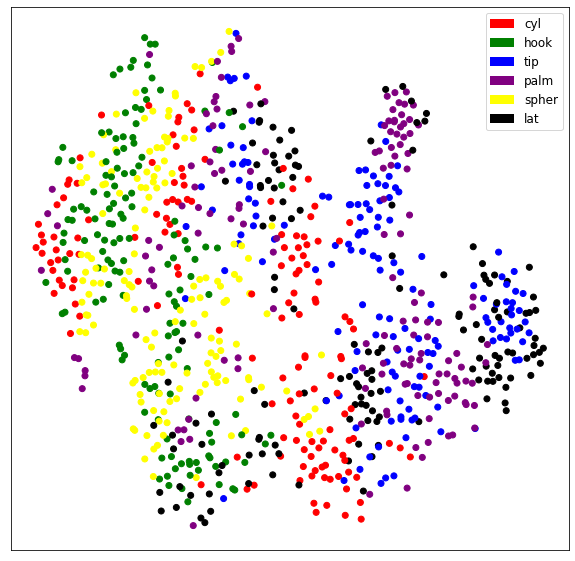

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  22.0 %
              precision    recall  f1-score   support

         cyl       0.36      0.27      0.31        30
        hook       0.00      0.00      0.00        30
         lat       0.00      0.00      0.00        30
        palm       0.33      0.07      0.11        30
       spher       0.32      0.27      0.29        30
         tip       0.21      0.70      0.32        30

    accuracy                           0.22       180
   macro avg       0.20      0.22      0.17       180
weighted avg       0.20      0.22      0.17       180

Training-Testing Total Runtime: 0.0013361334800720214 mins
Deployment Total Runtime: 7.327000300089518e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  22.0 %
              precision    recall  f1-score   support

         cyl       0.36      0.27      0.31        30
        hook       0.00      0.00      0.00        30
         lat       0.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.75      0.80      0.77        30
        hook       0.16      0.17      0.16        30
         lat       0.17      0.03      0.06        30
        palm       0.05      0.03      0.04        30
       spher       0.28      0.33      0.30        30
         tip       0.10      0.17      0.12        30

    accuracy                           0.26       180
   macro avg       0.25      0.26      0.24       180
weighted avg       0.25      0.26      0.24       180

Training-Testing Total Runtime: 0.005805766582489014 mins
Deployment Total Runtime: 0.0002216935157775879 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.75      0.80      0.77        30
        hook       0.16      0.17      0.16        30
         lat       0.17      0.03      0.06        30
        p

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.29      0.07      0.11        30
        hook       0.22      0.17      0.19        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.00      0.00      0.00        30
         tip       0.24      0.93      0.39        30

    accuracy                           0.19       180
   macro avg       0.12      0.19      0.11       180
weighted avg       0.12      0.19      0.11       180

Training-Testing Total Runtime: 0.016327281792958576 mins
Deployment Total Runtime: 0.0004970908164978027 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.29      0.07      0.11        30
        hook       0.22      0.17      0.19        30
         lat       0.00      0.00      0.00        30
        p

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.16591243346532186 mins


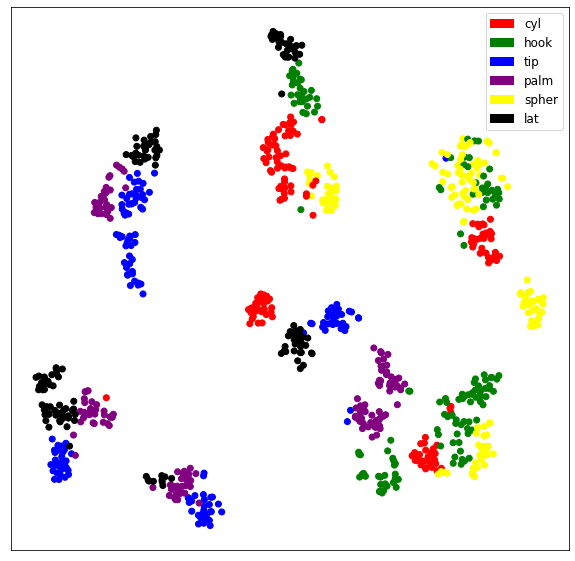

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  18.0 %
              precision    recall  f1-score   support

         cyl       0.17      0.17      0.17        30
        hook       0.09      0.10      0.09        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.21      0.77      0.32        30
         tip       1.00      0.07      0.12        30

    accuracy                           0.18       180
   macro avg       0.24      0.18      0.12       180
weighted avg       0.24      0.18      0.12       180

Training-Testing Total Runtime: 0.0009070118268330892 mins
Deployment Total Runtime: 5.8090686798095704e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  18.0 %
              precision    recall  f1-score   support

         cyl       0.17      0.17      0.17        30
        hook       0.09      0.10      0.09        30
         lat       0.00    

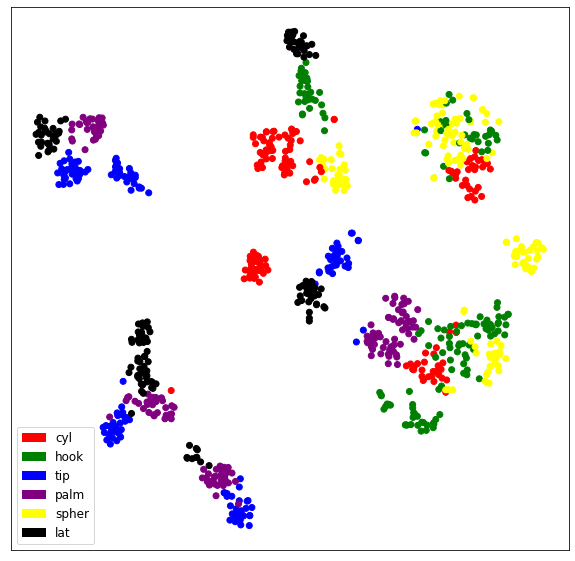

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.27      0.20      0.23        30
        hook       0.08      0.17      0.11        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.21      0.63      0.31        30
         tip       1.00      0.13      0.24        30

    accuracy                           0.19       180
   macro avg       0.26      0.19      0.15       180
weighted avg       0.26      0.19      0.15       180

Training-Testing Total Runtime: 0.0009747584660847982 mins
Deployment Total Runtime: 5.8698654174804685e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.27      0.20      0.23        30
        hook       0.08      0.17      0.11        30
         lat       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  41.0 %
              precision    recall  f1-score   support

         cyl       0.41      0.57      0.48        30
        hook       0.00      0.00      0.00        30
         lat       0.35      0.97      0.52        30
        palm       0.95      0.63      0.76        30
       spher       0.62      0.27      0.37        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.41       180
   macro avg       0.39      0.41      0.35       180
weighted avg       0.39      0.41      0.35       180

Training-Testing Total Runtime: 0.001769570509592692 mins
Deployment Total Runtime: 0.0003276745478312174 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  41.0 %
              precision    recall  f1-score   support

         cyl       0.41      0.57      0.48        30
        hook       0.00      0.00      0.00        30
         lat       0.35      0.97      0.52        30
        p

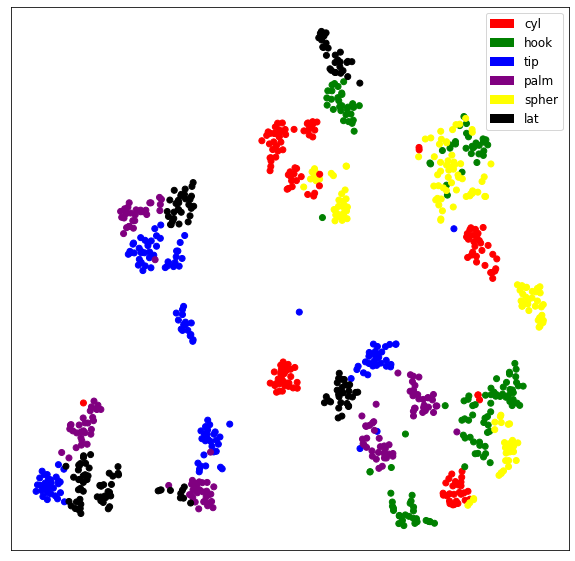

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.57      0.13      0.22        30
        hook       0.18      0.80      0.29        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.19      0.23      0.21        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.19       180
   macro avg       0.16      0.19      0.12       180
weighted avg       0.16      0.19      0.12       180

Training-Testing Total Runtime: 0.0011243383089701334 mins
Deployment Total Runtime: 6.031990051269531e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.57      0.13      0.22        30
        hook       0.18      0.80      0.29        30
         lat       0.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  39.0 %
              precision    recall  f1-score   support

         cyl       0.64      0.47      0.54        30
        hook       0.00      0.00      0.00        30
         lat       0.44      0.80      0.57        30
        palm       0.73      0.63      0.68        30
       spher       0.20      0.30      0.24        30
         tip       0.40      0.13      0.20        30

    accuracy                           0.39       180
   macro avg       0.40      0.39      0.37       180
weighted avg       0.40      0.39      0.37       180

Training-Testing Total Runtime: 0.0015123883883158367 mins
Deployment Total Runtime: 0.00023581584294637045 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  39.0 %
              precision    recall  f1-score   support

         cyl       0.64      0.47      0.54        30
        hook       0.00      0.00      0.00        30
         lat       0.44      0.80      0.57        30
       

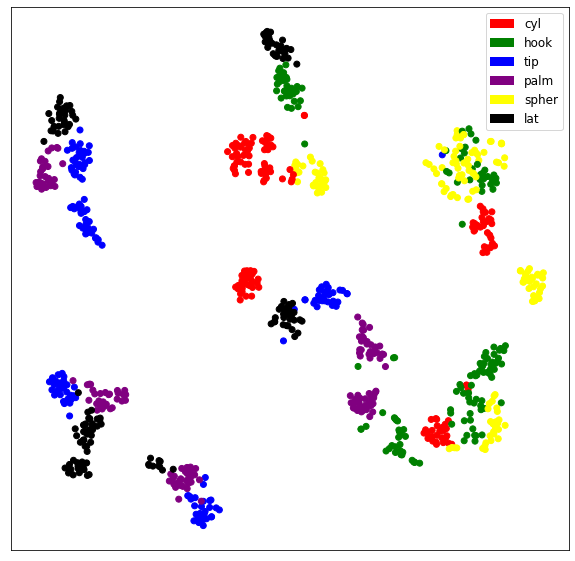

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  24.0 %
              precision    recall  f1-score   support

         cyl       0.60      0.20      0.30        30
        hook       0.20      0.90      0.33        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.26      0.27      0.26        30
         tip       1.00      0.10      0.18        30

    accuracy                           0.24       180
   macro avg       0.34      0.24      0.18       180
weighted avg       0.34      0.24      0.18       180

Training-Testing Total Runtime: 0.0011129061381022136 mins
Deployment Total Runtime: 5.840063095092773e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  24.0 %
              precision    recall  f1-score   support

         cyl       0.60      0.20      0.30        30
        hook       0.20      0.90      0.33        30
         lat       0.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  46.0 %
              precision    recall  f1-score   support

         cyl       0.72      0.70      0.71        30
        hook       0.00      0.00      0.00        30
         lat       0.46      0.60      0.52        30
        palm       0.86      0.80      0.83        30
       spher       0.12      0.10      0.11        30
         tip       0.57      0.57      0.57        30

    accuracy                           0.46       180
   macro avg       0.46      0.46      0.46       180
weighted avg       0.46      0.46      0.46       180

Training-Testing Total Runtime: 0.0014349699020385742 mins
Deployment Total Runtime: 0.00026137431462605794 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  46.0 %
              precision    recall  f1-score   support

         cyl       0.72      0.70      0.71        30
        hook       0.00      0.00      0.00        30
         lat       0.46      0.60      0.52        30
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.3583424806594849 mins
-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  28.999999999999996 %
              precision    recall  f1-score   support

         cyl       0.50      0.40      0.44        30
        hook       0.22      0.37      0.27        30
         lat       0.00      0.00      0.00        30
        palm       0.07      0.07      0.07        30
       spher       0.71      0.40      0.51        30
         tip       0.26      0.50      0.34        30

    accuracy                           0.29       180
  

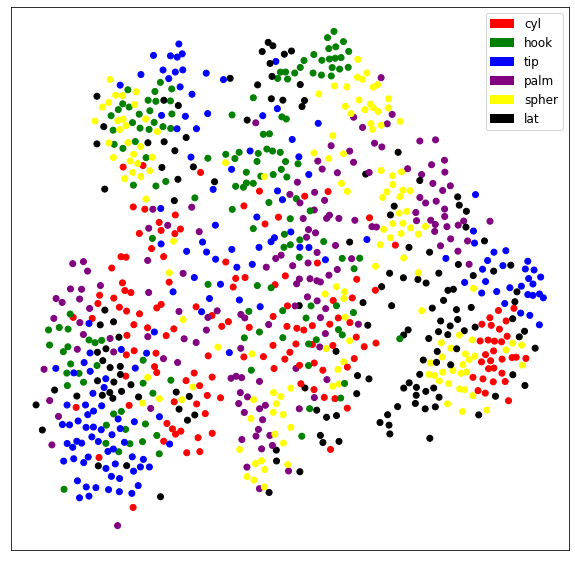

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.55      0.20      0.29        30
        hook       0.03      0.03      0.03        30
         lat       0.33      0.10      0.15        30
        palm       0.53      0.30      0.38        30
       spher       0.05      0.10      0.07        30
         tip       0.25      0.43      0.31        30

    accuracy                           0.19       180
   macro avg       0.29      0.19      0.21       180
weighted avg       0.29      0.19      0.21       180

Training-Testing Total Runtime: 0.0016317526499430338 mins
Deployment Total Runtime: 7.31507937113444e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.55      0.20      0.29        30
        hook       0.03      0.03      0.03        30
         lat       0.33      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
for i in all_features:
  print('--------------------------------------------------------------')
  print(i)
  features_signals = feature_extraction(five_subject,feature_name_list=[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  visualization(x,y,num_classes=6,legend=True,method="tsne")
  for z in classifier_list:
    ti = time.time() # time the feature extraction process
    print('-----------------------------')
    print(z)
    model = classification_train_test(x,y, classifier_string = z, dataset_type = "five_subjects")
    tf = time.time()
    print("Training-Testing Total Runtime:" ,(tf-ti)/60,"mins")
    # save the model to disk
    pickle.dump(model, open(f'{i}_{z}_{mode}_weight', 'wb'))
    
    # load the model from disk
    loaded_model = pickle.load(open(f'{i}_{z}_{mode}_weight', 'rb'))
    test, actual_classes = x[720:], y[720:]
    ti = time.time()
    prediction_classes = loaded_model.predict(test) # testing the classifier
    tf = time.time()
    print("Deployment Total Runtime:" ,(tf-ti)/60,"mins")         
    print("Test on TEST DATABASE",end="\n")
    print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    print(classification_report(actual_classes,prediction_classes))

--------------------------------------------------------------
['rms_window', 'variance', 'waveform_length', 'mean_absolute_value']
Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.37972257534662884 mins


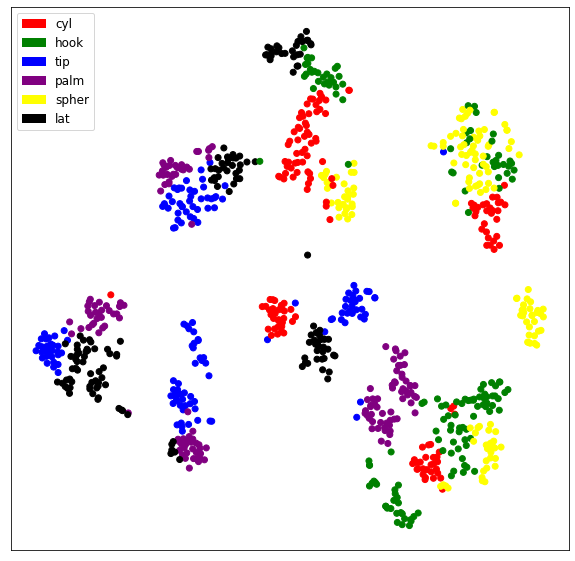

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  17.0 %
              precision    recall  f1-score   support

         cyl       0.20      0.20      0.20        30
        hook       0.11      0.13      0.12        30
         lat       0.00      0.00      0.00        30
        palm       0.06      0.03      0.04        30
       spher       0.19      0.50      0.28        30
         tip       0.45      0.17      0.24        30

    accuracy                           0.17       180
   macro avg       0.17      0.17      0.15       180
weighted avg       0.17      0.17      0.15       180

Training-Testing Total Runtime: 0.0015291293462117513 mins
Deployment Total Runtime: 0.00015528202056884765 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  17.0 %
              precision    recall  f1-score   support

         cyl       0.20      0.20      0.20        30
        hook       0.11      0.13      0.12        30
         lat       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Baseline Random is 16.7%
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.22      0.40      0.29        30
        hook       0.44      0.47      0.45        30
         lat       0.00      0.00      0.00        30
        palm       0.12      0.03      0.05        30
       spher       0.50      0.13      0.21        30
         tip       0.41      0.50      0.45        30

    accuracy                           0.26       180
   macro avg       0.28      0.26      0.24       180
weighted avg       0.28      0.26      0.24       180

Training-Testing Total Runtime: 0.00253142515818278 mins
Deployment Total Runtime: 7.616678873697916e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.22      0.40      0.29        30
        hook       0.44      0.47      0.45        30
         lat       0.00      0.00      0.00        30
        pa

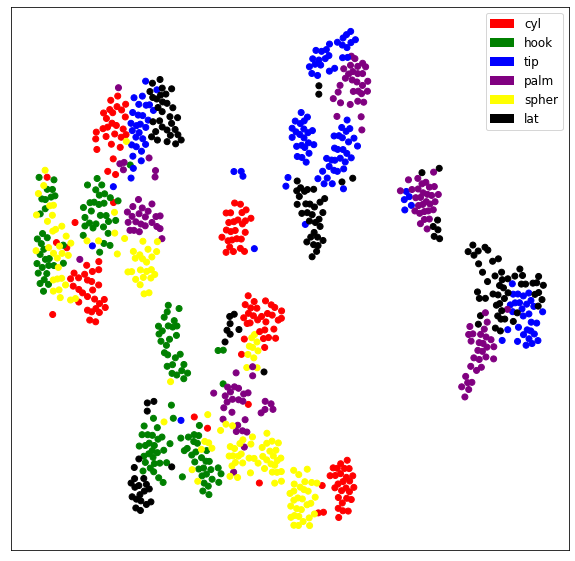

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.17      0.13      0.15        30
        hook       0.06      0.07      0.06        30
         lat       0.17      0.17      0.17        30
        palm       0.22      0.17      0.19        30
       spher       0.19      0.23      0.21        30
         tip       0.18      0.20      0.19        30

    accuracy                           0.16       180
   macro avg       0.16      0.16      0.16       180
weighted avg       0.16      0.16      0.16       180

Training-Testing Total Runtime: 0.0021915038426717124 mins
Deployment Total Runtime: 0.0003205617268880208 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.17      0.13      0.15        30
        hook       0.06      0.07      0.06        30
         lat       0.17     

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Baseline Random is 16.7%
Accuracy on test set is:  21.0 %
              precision    recall  f1-score   support

         cyl       0.06      0.10      0.07        30
        hook       0.26      0.40      0.31        30
         lat       0.00      0.00      0.00        30
        palm       0.27      0.13      0.18        30
       spher       0.62      0.27      0.37        30
         tip       0.48      0.37      0.42        30

    accuracy                           0.21       180
   macro avg       0.28      0.21      0.23       180
weighted avg       0.28      0.21      0.23       180

Training-Testing Total Runtime: 0.004456810156504313 mins
Deployment Total Runtime: 0.00016993284225463867 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  21.0 %
              precision    recall  f1-score   support

         cyl       0.06      0.10      0.07        30
        hook       0.26      0.40      0.31        30
         lat       0.00      0.00      0.00        30
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  22.0 %
              precision    recall  f1-score   support

         cyl       0.34      0.73      0.47        30
        hook       0.00      0.00      0.00        30
         lat       0.27      0.10      0.15        30
        palm       0.00      0.00      0.00        30
       spher       0.14      0.10      0.12        30
         tip       0.86      0.40      0.55        30

    accuracy                           0.22       180
   macro avg       0.27      0.22      0.21       180
weighted avg       0.27      0.22      0.21       180

Training-Testing Total Runtime: 0.0142729918162028 mins
Deployment Total Runtime: 0.0003606994946797689 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  22.0 %
              precision    recall  f1-score   support

         cyl       0.34      0.73      0.47        30
        hook       0.00      0.00      0.00        30
         lat       0.27      0.10      0.15        30
        pal

In [ ]:
the_features = {'4FE':four_features, 'ALL': all_features}
for i in the_features:
  print('--------------------------------------------------------------')
  print(the_features[i])
  features_signals = feature_extraction(five_subject,feature_name_list= the_features[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  visualization(x,y,num_classes=6,legend=True,method="tsne")
  for z in classifier_list:
    ti = time.time() # time the feature extraction process
    print('-----------------------------')
    print(z)
    model = classification_train_test(x,y, classifier_string = z, dataset_type = "five_subjects")
    tf = time.time()
    print("Training-Testing Total Runtime:" ,(tf-ti)/60,"mins")
    # save the model to disk
    pickle.dump(model, open(f'{i}_{z}_{mode}_weight', 'wb'))
    
    # load the model from disk
    loaded_model = pickle.load(open(f'{i}_{z}_{mode}_weight', 'rb'))
    test, actual_classes = x[720:], y[720:]
    ti = time.time()
    prediction_classes = loaded_model.predict(test) # testing the classifier
    tf = time.time()
    print("Deployment Total Runtime:" ,(tf-ti)/60,"mins")         
    print("Test on ONE SUBJECT DATABASE",end="\n")
    print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    print(classification_report(actual_classes,prediction_classes))

#####In loop: all features extraction with all classifier with pre-rpocess


In [ ]:
import pickle
%cd '/content/drive/MyDrive/SEM 04/TPIB/proyek mandiri-Kayla/model'
num_trials = 30
num_sessions = 5 # one subject on three different days
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # sklearn gives future warning which is not relevant here
classifier_list = ['qda','lda', 'svm', 'random_forest', 'extra_trees', 'grad_boost', 'gnb', 'adaboost']
four_features = ['rms_window', 'variance', 'waveform_length', 'mean_absolute_value'] #4 FE
all_features = ['wilson_amplitude', 'rms_window', 'variance', 'waveform_length', 'mean_absolute_value', 
                'zero_crossing', 'sign_slope_changes']
mode = 'PP' #mode without pre-processing

/content/drive/MyDrive/SEM 04/TPIB/proyek mandiri-Kayla/model


--------------------------------------------------------------
wilson_amplitude
Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.2814112345377604 mins


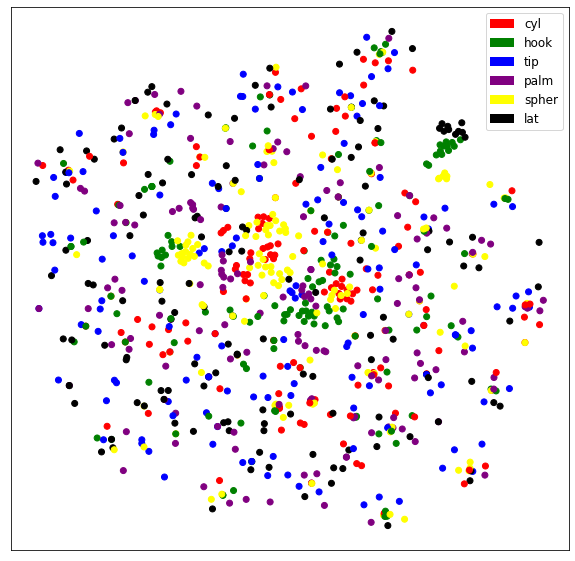

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  20.0 %
              precision    recall  f1-score   support

         cyl       0.15      0.07      0.09        30
        hook       0.22      0.43      0.30        30
         lat       0.14      0.03      0.05        30
        palm       0.09      0.03      0.05        30
       spher       0.21      0.47      0.29        30
         tip       0.21      0.17      0.19        30

    accuracy                           0.20       180
   macro avg       0.17      0.20      0.16       180
weighted avg       0.17      0.20      0.16       180

Training-Testing Total Runtime: 0.000986635684967041 mins
Deployment Total Runtime: 7.392168045043946e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  20.0 %
              precision    recall  f1-score   support

         cyl       0.15      0.07      0.09        30
        hook       0.22      0.43      0.30        30
         lat       0.14      

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Baseline Random is 16.7%
Accuracy on test set is:  7.000000000000001 %
              precision    recall  f1-score   support

         cyl       0.40      0.07      0.11        30
        hook       0.09      0.27      0.13        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.04      0.10      0.05        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.07       180
   macro avg       0.09      0.07      0.05       180
weighted avg       0.09      0.07      0.05       180

Training-Testing Total Runtime: 0.0021092454592386884 mins
Deployment Total Runtime: 0.00025580326716105145 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  7.000000000000001 %
              precision    recall  f1-score   support

         cyl       0.40      0.07      0.11        30
        hook       0.09      0.27      0.13        30
         lat       0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  7.000000000000001 %
              precision    recall  f1-score   support

         cyl       0.29      0.17      0.21        30
        hook       0.18      0.13      0.15        30
         lat       0.00      0.00      0.00        30
        palm       0.04      0.07      0.05        30
       spher       0.00      0.00      0.00        30
         tip       0.03      0.03      0.03        30

    accuracy                           0.07       180
   macro avg       0.09      0.07      0.07       180
weighted avg       0.09      0.07      0.07       180

Training-Testing Total Runtime: 0.004625483353932699 mins
Deployment Total Runtime: 0.002355515956878662 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  7.000000000000001 %
              precision    recall  f1-score   support

         cyl       0.29      0.17      0.21        30
        hook       0.18      0.13      0.15        30
         lat       0.00      0.00     

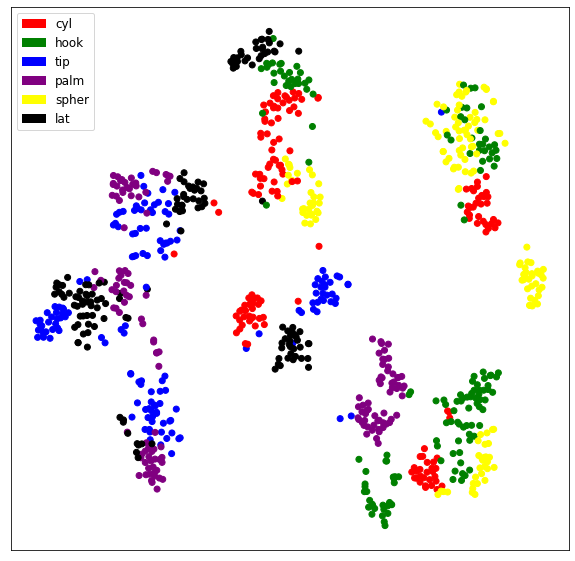

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  12.0 %
              precision    recall  f1-score   support

         cyl       0.00      0.00      0.00        30
        hook       0.06      0.17      0.08        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.20      0.50      0.29        30
         tip       1.00      0.03      0.06        30

    accuracy                           0.12       180
   macro avg       0.21      0.12      0.07       180
weighted avg       0.21      0.12      0.07       180

Training-Testing Total Runtime: 0.0011088053385416667 mins
Deployment Total Runtime: 5.925496419270833e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  12.0 %
              precision    recall  f1-score   support

         cyl       0.00      0.00      0.00        30
        hook       0.06      0.17      0.08        30
         lat       0.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  28.999999999999996 %
              precision    recall  f1-score   support

         cyl       0.29      0.47      0.35        30
        hook       0.00      0.00      0.00        30
         lat       0.36      0.80      0.50        30
        palm       0.93      0.43      0.59        30
       spher       0.06      0.03      0.04        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.29       180
   macro avg       0.27      0.29      0.25       180
weighted avg       0.27      0.29      0.25       180

Training-Testing Total Runtime: 0.0017953991889953613 mins
Deployment Total Runtime: 0.00030350287755330404 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  28.999999999999996 %
              precision    recall  f1-score   support

         cyl       0.29      0.47      0.35        30
        hook       0.00      0.00      0.00        30
         lat       0.36      0.80

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.17796618541081746 mins


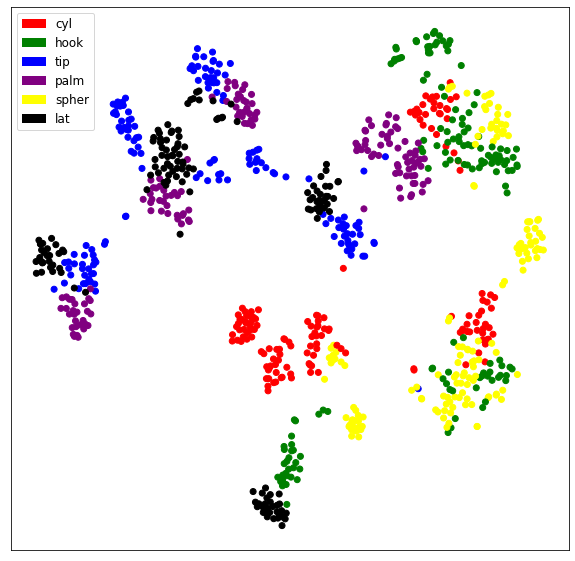

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.29      0.07      0.11        30
        hook       0.18      0.70      0.28        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.49      0.77      0.60        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.26       180
   macro avg       0.16      0.26      0.16       180
weighted avg       0.16      0.26      0.16       180

Training-Testing Total Runtime: 0.0008967995643615722 mins
Deployment Total Runtime: 6.12338383992513e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.29      0.07      0.11        30
        hook       0.18      0.70      0.28        30
         lat       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.46      0.40      0.43        30
        hook       0.00      0.00      0.00        30
         lat       0.17      0.43      0.24        30
        palm       0.87      0.43      0.58        30
       spher       0.62      0.27      0.37        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.26       180
   macro avg       0.35      0.26      0.27       180
weighted avg       0.35      0.26      0.27       180

Training-Testing Total Runtime: 0.0015491922696431479 mins
Deployment Total Runtime: 0.000245209534962972 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.46      0.40      0.43        30
        hook       0.00      0.00      0.00        30
         lat       0.17      0.43      0.24        30
        p

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.26971031030019127 mins


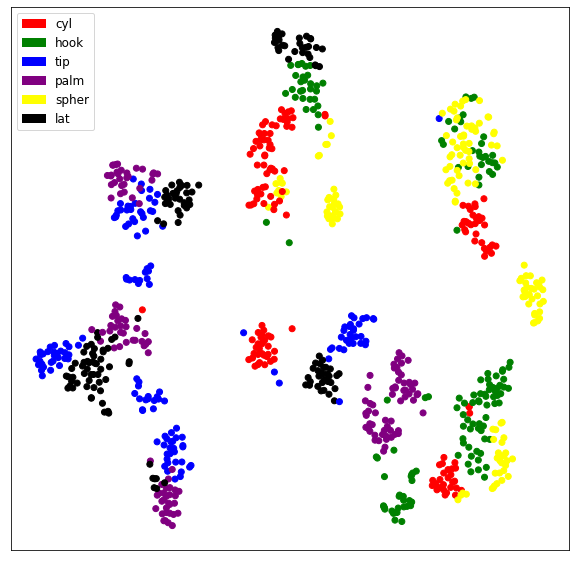

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.10      0.13      0.11        30
        hook       0.17      0.53      0.25        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.21      0.27      0.23        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.16       180
   macro avg       0.08      0.16      0.10       180
weighted avg       0.08      0.16      0.10       180

Training-Testing Total Runtime: 0.001067519187927246 mins
Deployment Total Runtime: 7.555087407430013e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.10      0.13      0.11        30
        hook       0.17      0.53      0.25        30
         lat       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.50      0.47      0.48        30
        hook       0.00      0.00      0.00        30
         lat       0.07      0.10      0.09        30
        palm       0.88      0.47      0.61        30
       spher       0.07      0.10      0.08        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.19       180
   macro avg       0.25      0.19      0.21       180
weighted avg       0.25      0.19      0.21       180

Training-Testing Total Runtime: 0.0014485359191894532 mins
Deployment Total Runtime: 0.0002822279930114746 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.50      0.47      0.48        30
        hook       0.00      0.00      0.00        30
         lat       0.07      0.10      0.09        30
        

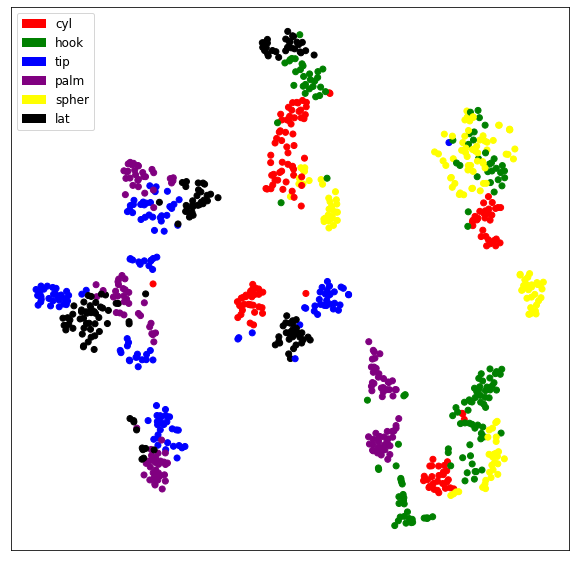

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  17.0 %
              precision    recall  f1-score   support

         cyl       0.25      0.03      0.06        30
        hook       0.17      0.87      0.29        30
         lat       0.00      0.00      0.00        30
        palm       0.00      0.00      0.00        30
       spher       0.14      0.10      0.12        30
         tip       0.00      0.00      0.00        30

    accuracy                           0.17       180
   macro avg       0.09      0.17      0.08       180
weighted avg       0.09      0.17      0.08       180

Training-Testing Total Runtime: 0.0010660966237386069 mins
Deployment Total Runtime: 6.01967175801595e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  17.0 %
              precision    recall  f1-score   support

         cyl       0.25      0.03      0.06        30
        hook       0.17      0.87      0.29        30
         lat       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  21.0 %
              precision    recall  f1-score   support

         cyl       0.34      0.57      0.42        30
        hook       0.00      0.00      0.00        30
         lat       0.25      0.40      0.31        30
        palm       0.86      0.20      0.32        30
       spher       0.05      0.03      0.04        30
         tip       0.05      0.03      0.04        30

    accuracy                           0.21       180
   macro avg       0.26      0.21      0.19       180
weighted avg       0.26      0.21      0.19       180

Training-Testing Total Runtime: 0.0014871994654337565 mins
Deployment Total Runtime: 0.00022562742233276368 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  21.0 %
              precision    recall  f1-score   support

         cyl       0.34      0.57      0.42        30
        hook       0.00      0.00      0.00        30
         lat       0.25      0.40      0.31        30
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.31682186126708983 mins


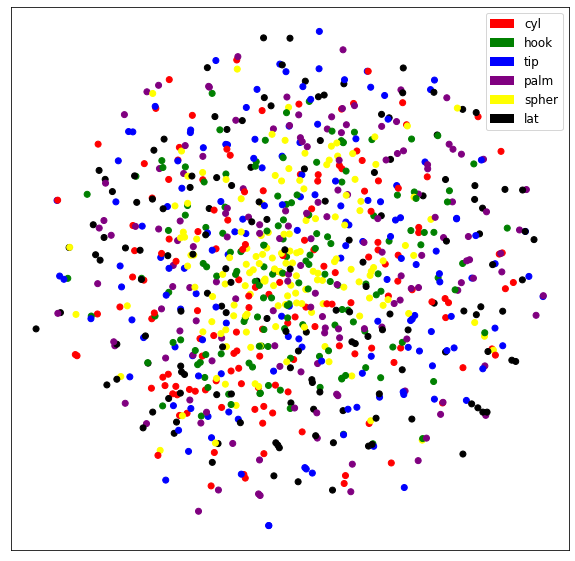

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.50      0.13      0.21        30
        hook       0.33      0.07      0.11        30
         lat       0.18      0.37      0.24        30
        palm       0.26      0.40      0.32        30
       spher       0.00      0.00      0.00        30
         tip       0.11      0.20      0.14        30

    accuracy                           0.19       180
   macro avg       0.23      0.19      0.17       180
weighted avg       0.23      0.19      0.17       180

Training-Testing Total Runtime: 0.001312871774037679 mins
Deployment Total Runtime: 7.60634740193685e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.50      0.13      0.21        30
        hook       0.33      0.07      0.11        30
         lat       0.18      0

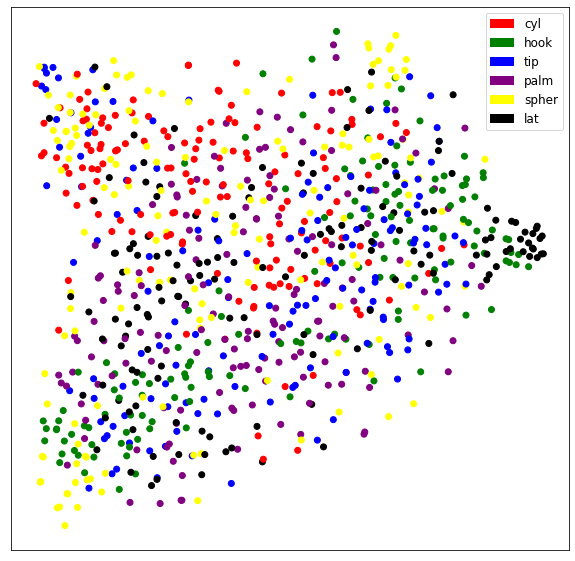

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.20      0.10      0.13        30
        hook       0.17      0.27      0.21        30
         lat       0.20      0.33      0.25        30
        palm       0.00      0.00      0.00        30
       spher       0.12      0.10      0.11        30
         tip       0.11      0.13      0.12        30

    accuracy                           0.16       180
   macro avg       0.13      0.16      0.14       180
weighted avg       0.13      0.16      0.14       180

Training-Testing Total Runtime: 0.0011124690373738608 mins
Deployment Total Runtime: 8.647441864013672e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.20      0.10      0.13        30
        hook       0.17      0.27      0.21        30
         lat       0.20     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  9.0 %
              precision    recall  f1-score   support

         cyl       0.35      0.27      0.30        30
        hook       0.15      0.10      0.12        30
         lat       0.03      0.03      0.03        30
        palm       0.05      0.10      0.07        30
       spher       0.00      0.00      0.00        30
         tip       0.03      0.03      0.03        30

    accuracy                           0.09       180
   macro avg       0.10      0.09      0.09       180
weighted avg       0.10      0.09      0.09       180

Training-Testing Total Runtime: 0.006883577505747477 mins
Deployment Total Runtime: 0.00024365981419881185 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  9.0 %
              precision    recall  f1-score   support

         cyl       0.35      0.27      0.30        30
        hook       0.15      0.10      0.12        30
         lat       0.03      0.03      0.03        30
        pa

In [ ]:
for i in all_features:
  print('--------------------------------------------------------------')
  print(i)
  features_signals = feature_extraction(processed_emg,feature_name_list=[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  visualization(x,y,num_classes=6,legend=True,method="tsne")
  for z in classifier_list:
    ti = time.time() # time the feature extraction process
    print('-----------------------------')
    print(z)
    model = classification_train_test(x,y, classifier_string = z, dataset_type = "five_subjects")
    tf = time.time()
    print("Training-Testing Total Runtime:" ,(tf-ti)/60,"mins")
    # save the model to disk
    pickle.dump(model, open(f'{i}_{z}_{mode}_weight', 'wb'))
    
    # load the model from disk
    loaded_model = pickle.load(open(f'{i}_{z}_{mode}_weight', 'rb'))
    test, actual_classes = x[720:], y[720:]
    ti = time.time()
    prediction_classes = loaded_model.predict(test) # testing the classifier
    tf = time.time()
    print("Deployment Total Runtime:" ,(tf-ti)/60,"mins")         
    print("Test on ONE SUBJECT DATABASE",end="\n")
    print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    print(classification_report(actual_classes,prediction_classes))

--------------------------------------------------------------
['rms_window', 'variance', 'waveform_length', 'mean_absolute_value']
Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.5085193316141764 mins


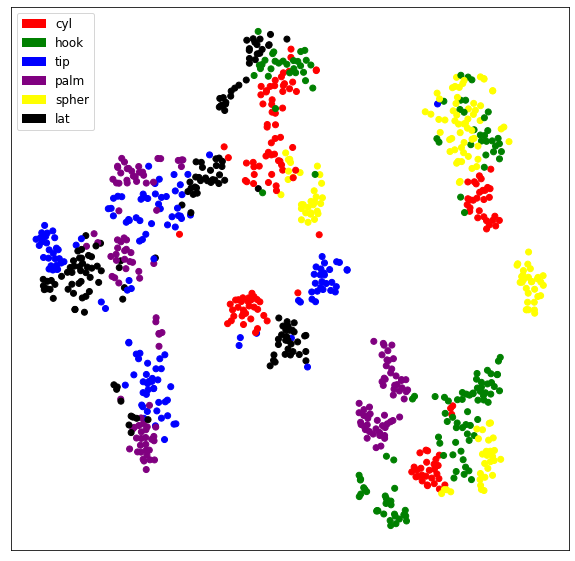

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.15      0.20      0.17        30
        hook       0.15      0.17      0.16        30
         lat       0.30      0.10      0.15        30
        palm       0.28      0.17      0.21        30
       spher       0.19      0.40      0.26        30
         tip       0.20      0.10      0.13        30

    accuracy                           0.19       180
   macro avg       0.21      0.19      0.18       180
weighted avg       0.21      0.19      0.18       180

Training-Testing Total Runtime: 0.0015712380409240723 mins
Deployment Total Runtime: 0.00020718971888224283 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  19.0 %
              precision    recall  f1-score   support

         cyl       0.15      0.20      0.17        30
        hook       0.15      0.17      0.16        30
         lat       0.30    

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Baseline Random is 16.7%
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.13      0.17      0.14        30
        hook       0.45      0.17      0.24        30
         lat       0.00      0.00      0.00        30
        palm       0.24      0.17      0.20        30
       spher       0.75      0.30      0.43        30
         tip       0.08      0.17      0.11        30

    accuracy                           0.16       180
   macro avg       0.28      0.16      0.19       180
weighted avg       0.28      0.16      0.19       180

Training-Testing Total Runtime: 0.0026483694712320966 mins
Deployment Total Runtime: 8.302927017211914e-05 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  16.0 %
              precision    recall  f1-score   support

         cyl       0.13      0.17      0.14        30
        hook       0.45      0.17      0.24        30
         lat       0.00      0.00      0.00        30
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.753853714466095 mins


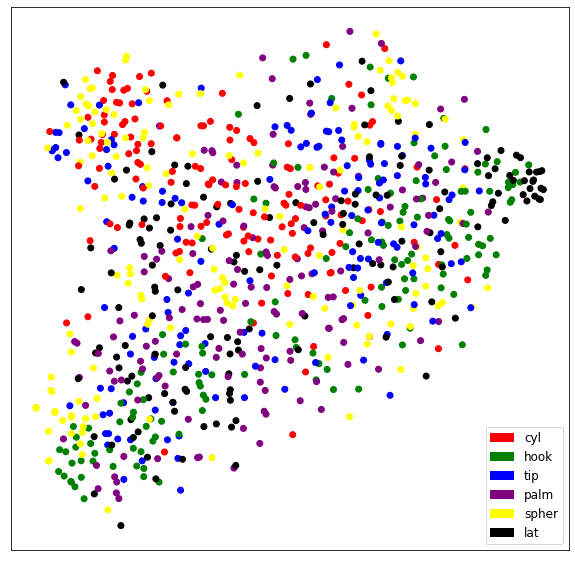

-----------------------------
qda
Baseline Random is 16.7%
Accuracy on test set is:  11.0 %
              precision    recall  f1-score   support

         cyl       0.07      0.07      0.07        30
        hook       0.11      0.17      0.14        30
         lat       0.12      0.10      0.11        30
        palm       0.19      0.13      0.16        30
       spher       0.09      0.13      0.11        30
         tip       0.06      0.03      0.04        30

    accuracy                           0.11       180
   macro avg       0.11      0.11      0.10       180
weighted avg       0.11      0.11      0.10       180

Training-Testing Total Runtime: 0.0023380319277445474 mins
Deployment Total Runtime: 0.00030066967010498045 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  11.0 %
              precision    recall  f1-score   support

         cyl       0.07      0.07      0.07        30
        hook       0.11      0.17      0.14        30
         lat       0.12    

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Baseline Random is 16.7%
Accuracy on test set is:  18.0 %
              precision    recall  f1-score   support

         cyl       0.12      0.13      0.12        30
        hook       0.28      0.40      0.33        30
         lat       0.00      0.00      0.00        30
        palm       0.03      0.03      0.03        30
       spher       0.47      0.23      0.31        30
         tip       0.30      0.30      0.30        30

    accuracy                           0.18       180
   macro avg       0.20      0.18      0.18       180
weighted avg       0.20      0.18      0.18       180

Training-Testing Total Runtime: 0.004700112342834473 mins
Deployment Total Runtime: 0.0001865228017171224 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  18.0 %
              precision    recall  f1-score   support

         cyl       0.12      0.13      0.12        30
        hook       0.28      0.40      0.33        30
         lat       0.00      0.00      0.00        30
        p

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Baseline Random is 16.7%
Accuracy on test set is:  27.0 %
              precision    recall  f1-score   support

         cyl       0.47      0.60      0.53        30
        hook       0.00      0.00      0.00        30
         lat       0.60      0.80      0.69        30
        palm       0.00      0.00      0.00        30
       spher       0.00      0.00      0.00        30
         tip       0.88      0.23      0.37        30

    accuracy                           0.27       180
   macro avg       0.32      0.27      0.26       180
weighted avg       0.32      0.27      0.26       180

Training-Testing Total Runtime: 0.012691624959309896 mins
Deployment Total Runtime: 0.00037208000818888344 mins
Test on ONE SUBJECT DATABASE
Accuracy on test set is:  27.0 %
              precision    recall  f1-score   support

         cyl       0.47      0.60      0.53        30
        hook       0.00      0.00      0.00        30
         lat       0.60      0.80      0.69        30
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
the_features = {'4FE':four_features, 'ALL': all_features}
for i in the_features:
  print('--------------------------------------------------------------')
  print(the_features[i])
  features_signals = feature_extraction(processed_emg,feature_name_list= the_features[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  visualization(x,y,num_classes=6,legend=True,method="tsne")
  for z in classifier_list:
    ti = time.time() # time the feature extraction process
    print('-----------------------------')
    print(z)
    model = classification_train_test(x,y, classifier_string = z, dataset_type = "five_subjects")
    tf = time.time()
    print("Training-Testing Total Runtime:" ,(tf-ti)/60,"mins")
    # save the model to disk
    pickle.dump(model, open(f'{i}_{z}_{mode}_weight', 'wb'))
    
    # load the model from disk
    loaded_model = pickle.load(open(f'{i}_{z}_{mode}_weight', 'rb'))
    test, actual_classes = x[720:], y[720:]
    ti = time.time()
    prediction_classes = loaded_model.predict(test) # testing the classifier
    tf = time.time()
    print("Deployment Total Runtime:" ,(tf-ti)/60,"mins")         
    print("Test on ONE SUBJECT DATABASE",end="\n")
    print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    print(classification_report(actual_classes,prediction_classes))

Code base

This framework and result developed on top of [Lawrobel's Code](https://github.com/lawrobel/EMG-Data-Analysis)